In [1]:
import ir_datasets
import pandas as pd

# Trec-Covid

In [3]:
d = {}
for t in [1, 2, 3, 4, 5]:
    print(f"Round {t}")
    dataset = ir_datasets.load(f"cord19/trec-covid/round{t}")


    # Documents
    docs_df = []
    for doc in dataset.docs_iter():
        docs_df.append({"docid": doc.doc_id, "title": doc.title, "date": doc.date, "title_len": len(doc.title.split()), "abstract_len": len(doc.abstract.split()), "total_len": len(doc.title.split()) + len(doc.abstract.split())})

    docs_df = pd.DataFrame(docs_df)

    d[t] = {}
    d[t]["docids_unique"] = docs_df["docid"].unique().tolist()
    d[t]["num_docs"] = len(docs_df["docid"].unique())
    d[t]["docids"] = docs_df["docid"].tolist()
    d[t]["docs_len_mean"] = docs_df["total_len"].mean()
    d[t]["docs_len_min"] = docs_df["total_len"].min()
    d[t]["docs_len_max"] = docs_df["total_len"].max()
    d[t]["docs_len_patch"] = docs_df[["docid", "total_len"]].drop_duplicates("docid").set_index("docid")["total_len"].to_dict()
    
    previous_docids = d.get(t-1, {"docids_unique": []})["docids_unique"]
    d[t]["docs_added"] = len(set(d[t]["docids_unique"]) - set(previous_docids))
    d[t]["docs_removed"] = len(set(previous_docids) - set(d[t]["docids_unique"]))
    d[t]["docs_kept"] = len(set(d[t]["docids_unique"]) & set(previous_docids))
    d[t]["docs_longer"] = 0
    d[t]["docs_shorter"] = 0
    d[t]["docs_same"] = 0

    for docid in d[t]["docids_unique"]:
        if docid in previous_docids:
            if d[t]["docs_len_patch"][docid] > d[t-1]["docs_len_patch"][docid]:
                d[t]["docs_longer"] += 1
            elif d[t]["docs_len_patch"][docid] < d[t-1]["docs_len_patch"][docid]:
                d[t]["docs_shorter"] += 1
            else:
                d[t]["docs_same"] += 1


    # Queries
    queries_df = []
    for query in dataset.queries_iter():
        queries_df.append({"qid": query.query_id, "title": query.title, "query_len": len(query.title.split())})

    queries_df = pd.DataFrame(queries_df)

    d[t]["qids"] = queries_df["qid"].tolist()
    d[t]["qids_unique"] = queries_df["qid"].unique().tolist()
    d[t]["num_queries"] = len(queries_df["title"].unique())
    d[t]["query_mean"] = queries_df["query_len"].mean()
    d[t]["query_min"] = queries_df["query_len"].min()
    d[t]["query_max"] = queries_df["query_len"].max()



Round 1
Round 2
Round 3
Round 4
Round 5


In [4]:
import json
import numpy as np

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

In [68]:
import json

with open("trec_covid.json", "w") as file:
    json.dump(d, file, indent=4, default=np_encoder)

In [6]:
table = []
for t in [1, 2, 3, 4, 5]:
    table.append([t, d[t]["num_docs"], d[t]["docs_added"], d[t]["docs_removed"], d[t]["docs_kept"], d[t]["docs_longer"], d[t]["docs_shorter"], d[t]["docs_same"], d[t]["num_queries"], d[t]["query_mean"], d[t]["query_min"], d[t]["query_max"]])

tc = pd.DataFrame(table, columns=["Round", "Num Docs", "Docs Added", "Docs Removed", "Docs Kept", "Docs Longer", "Docs Shorter", "Docs Same", "Num Queries", "Query Mean", "Query Min", "Query Max"])

In [12]:
# % Change
(tc["Docs Same"] *100)/tc["Num Docs"]-100

0   -100.000000
1    -15.064076
2    -65.565456
3    -28.658510
4    -22.363280
dtype: float64

In [27]:
((tc["Num Queries"][:-1].reset_index() *100)/ tc["Num Queries"][1:].reset_index())-100

,index,Num Queries
0,-100.000000,-14.285714
1,-50.000000,-12.500000
2,-33.333333,-11.111111
3,-25.000000,-10.000000


In [20]:
tc["Num Queries"][1:] 

1    35
2    40
3    45
4    50
Name: Num Queries, dtype: int64

# TripClick

In [28]:
table = []
with open('metadata_processed.jsonl', 'r') as file:
    for line in file.readlines():
        line = json.loads(line)
        try:
            table.append((line["tripclick_id"], line["year"]))
        except:
            # print(line)
            pass

In [29]:
data = pd.DataFrame(table, columns=["tripclick_id", "year"])

In [30]:
data["sub-collection"] = pd.qcut(data["year"], 3, labels=["t1", "t2", "t3"])#.value_counts()

In [34]:
tc_stats = data.groupby("sub-collection").count()
tc_stats

,tripclick_id,year
sub-collection,,
t1,565737,565737
t2,519357,519357
t3,425649,425649


In [37]:
tc_stats["cumsum"] = tc_stats["tripclick_id"].cumsum()

In [38]:
tc_stats

,tripclick_id,year,same,cumsum
sub-collection,,,,
t1,565737,565737,NaN,565737
t2,519357,519357,1085094.0,1085094
t3,425649,425649,945006.0,1510743


In [43]:
tc_stats["cumsum"][1:].reset_index()

,sub-collection,cumsum
0,t2,1085094
1,t3,1510743


In [46]:
((tc_stats["tripclick_id"][:-1].reset_index()["tripclick_id"] *100)/ tc_stats["cumsum"][1:].reset_index()["cumsum"])-100

0   -47.862858
1   -65.622412
dtype: float64

In [47]:
year

NameError: name 'year' is not defined

In [31]:
patch_dict=data.set_index("tripclick_id")["sub-collection"].to_dict()

In [ ]:
# with open("tripclick-subcollections.json", "w") as file:
#     json.dump(patch_dict, file)

In [ ]:
len(data["year"].dropna())-1524989  # missing

<Axes: title={'center': 'TripClick: Number of publications per year'}>

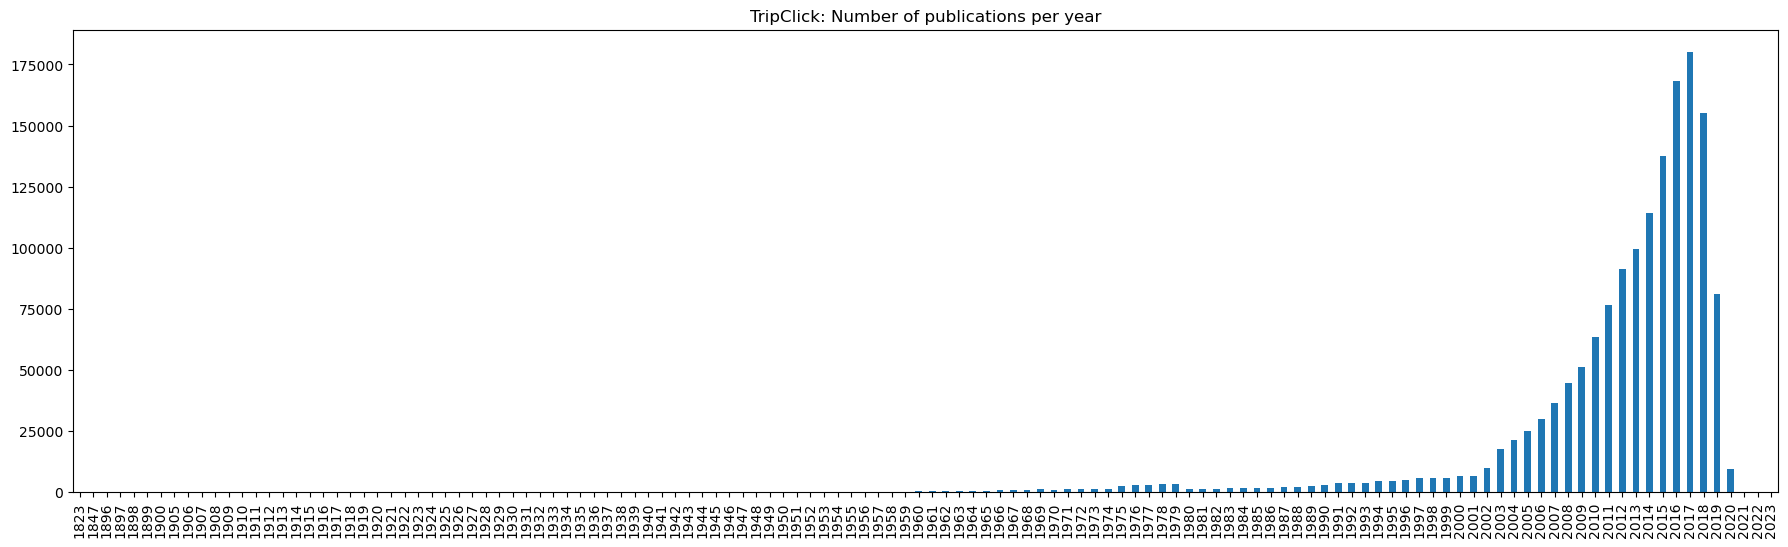

In [48]:
years = data["year"].dropna().apply(lambda x: int(x))
years.value_counts().sort_index().plot(kind="bar", figsize=(22, 6), title="TripClick: Number of publications per year")

In [54]:
data.groupby("sub-collection").min()

,tripclick_id,year
sub-collection,,
t1,1000001,1823.0
t2,10000107,2013.0
t3,10000005,2017.0


In [55]:
data.groupby("sub-collection").max()

,tripclick_id,year
sub-collection,,
t1,999997,2012.0
t2,9998491,2016.0
t3,9999999,2023.0


# LongEval

In [59]:
le_stats = {"total": [1570734, 1593376, 1081334], 
 "same": [0, 1355835, 841873]}


In [62]:
le_stats = pd.DataFrame(le_stats)
le_stats

,total,same
0,1570734,0
1,1593376,1355835
2,1081334,841873


In [69]:
((le_stats["same"] *100)/ le_stats["total"])-100

0   -100.000000
1    -14.908032
2    -22.144962
dtype: float64

In [68]:
le_stats["same"]

0          0
1    1355835
2     841873
Name: same, dtype: int64

In [75]:
le_stats_q = {"total": [753, 860, 910], 
 "same": [0, 139, 130]}

In [76]:
le_stats_q = pd.DataFrame(le_stats_q)
le_stats_q

,total,same
0,753,0
1,860,139
2,910,130


In [77]:
le_stats_q["same"] += 124

In [78]:
le_stats_q

,total,same
0,753,124
1,860,263
2,910,254


In [79]:
((le_stats_q["same"] *100)/ le_stats_q["total"])-100

0   -83.532537
1   -69.418605
2   -72.087912
dtype: float64